<h1><center> Surface adatom diffusion and bulk vacancy using an EAM Potential</center></h1>

References: 
  [1] AP275 Labs, Boris Kozinsky (Harvard U), https://github.com/bkoz37/labutil
  
Simon Batzner    

## Params

You will need to set the same environment variables as used in the labs: 

    1. LAMMPS_COMMAND=<path-to-lammps-executable>
    2. LAMMPS_POTENTIALS=<path-to-dir-with-lammps-potential-files>
    
As well as your current working directory:

In [2]:
import os
workdir = '/home/sbatzner/ML-electron-density/EAM'

Also note that you can set whether you're runnning this notebook remotely or local - in case it's run remotely, the lammps mpi command will be run with -np 32

In [3]:
# running on local or remote 
remote = True

In [4]:
print("\nworking directory: {}".format(workdir))
print("lammps executable: {}".format(os.environ['LAMMPS_COMMAND']))
print("lammps potentials: {}\n".format(os.environ['LAMMPS_POTENTIALS']))


working directory: /home/sbatzner/ML-electron-density/EAM
lammps executable: /home/sbatzner/lammps-16Mar18/src/lmp_mpi
lammps potentials: /home/sbatzner/lammps-16Mar18/potentials



## Notes
    
    1. Adataom diffusion: 
    
    - bulk is created, relaxed with eam potential, and alat is extracted
    - that alat is then used to create a fcc111 surface slab
    - the bottom n-2 layers of that slab are frozen while the top 2 layers are relaxed
    - finally, an adatom is added 2 angstrom above the top layer and MD is run in either an NVE or NVT setting; the MSD of the adatom is recorded to track diffusion
      
    2. Bulk vacancy: 
    
    - perfect cell is createad, relaxed with eam potential, alat is extracted
    - atom in the middle of the structure is removed via pop(), structure is relaxed w/o allowing the lattice 
      param to vary
    - md is run

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from src.plugins.lammps import *
from src.objects import *
from ase.build import *
from ase.io import read, write
from ase.spacegroup import crystal
from ase.constraints import FixAtoms
from ase.visualize import view

In [6]:
# whether to write .cif file and qe input file with structure data when creating systems
write_cif = False
write_qe = False

## Templates for MD run, relaxations, and single-point calculations

In [7]:
# relax with allowing the unit cell to vary

input_template_relax = """
# ---------- 1. Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT

# ---------- 2. Specify interatomic potential ---------------------
pair_style eam
pair_coeff * * $POTENTIAL

# -- include optimization of the unit cell parameter
fix 1 all box/relax iso 0.0 vmax 0.001

# -- enable optimization of atomic positions (and the cell)
min_style cg
minimize 1e-10 1e-10 100000 10000000


# ---- 4. Define and print useful variables -------------
variable natoms equal "count(all)"
variable totenergy equal "pe"
variable length equal "lx"

print "Total energy (eV) = ${totenergy}"
print "Number of atoms = ${natoms}"
print "Lattice constant (Angstoms) = ${length}"
        """

In [8]:
# relax w/o allowing the unit cell to vary

input_template_relax_wo_vc = """
# ---------- 1. Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT

# ---------- 2. Specify interatomic potential ---------------------
pair_style eam
pair_coeff * * $POTENTIAL

# -- enable optimization of atomic positions 
min_style cg
minimize 1e-10 1e-10 100000 10000000

# ---- 4. Define and print useful variables -------------
variable natoms equal "count(all)"
variable totenergy equal "pe"
variable length equal "lx"

write_dump all atom rel_wo_vc.out modify sort id

print "Total energy (eV) = ${totenergy}"
print "Number of atoms = ${natoms}"
print "Lattice constant (Angstoms) = ${length}"
        """

In [9]:
# template to fix bottom layers and keep top 2 
# TODO: parametrize this
# TODO: include lattice param relax or not? 

input_template_fix2l = """
# ---------- 1. Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT

# ---------- 2. Specify interatomic potential ---------------------
pair_style eam
pair_coeff * * $POTENTIAL

# -- include optimization of the unit cell parameter
fix 1 all box/relax iso 0.0 vmax 0.001

# -- fix all layers except for top two layers
group bottom id 1:25200
group top id 25201:27000

fix 2 bottom setforce 0.0 0.0 0.0
velocity bottom set 0.0 0.0 0.0

# -- enable optimization of atomic positions (and the cell)
min_style cg
minimize 1e-10 1e-10 100000 10000000


# ---- 4. Define and print useful variables -------------
variable natoms equal "count(all)"
variable totenergy equal "pe"
variable length equal "lx"
write_dump all atom fix2l_.out modify sort id


print "Total energy (eV) = ${totenergy}"
print "Number of atoms = ${natoms}"
print "Lattice constant (Angstoms) = ${length}"
        """

In [10]:
# template to fix bottom layers and keep top3
# TODO: parametrize this
# TODO: include lattice param relax or not? 

input_template_fix3l = """
# ---------- 1. Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT

# ---------- 2. Specify interatomic potential ---------------------
pair_style eam
pair_coeff * * $POTENTIAL

# -- include optimization of the unit cell parameter
fix 1 all box/relax iso 0.0 vmax 0.001

# -- fix all layers except for top two layers
group bottom id 1:24300
group top id 24301:27000

fix 2 bottom setforce 0.0 0.0 0.0
velocity bottom set 0.0 0.0 0.0

# -- enable optimization of atomic positions (and the cell)
min_style cg
minimize 1e-10 1e-10 100000 10000000


# ---- 4. Define and print useful variables -------------
variable natoms equal "count(all)"
variable totenergy equal "pe"
variable length equal "lx"
write_dump all atom fix3l_.out modify sort id


print "Total energy (eV) = ${totenergy}"
print "Number of atoms = ${natoms}"
print "Lattice constant (Angstoms) = ${length}"
        """

In [11]:
# template to fix bottom layers and keep top 4
# TODO: parametrize this
# TODO: include lattice param relax or not? 

input_template_fix4l = """
# ---------- 1. Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT

# ---------- 2. Specify interatomic potential ---------------------
pair_style eam
pair_coeff * * $POTENTIAL

# -- include optimization of the unit cell parameter
fix 1 all box/relax iso 0.0 vmax 0.001

# -- fix all layers except for top two layers
group bottom id 1:23400
group top id 23401:27000

fix 2 bottom setforce 0.0 0.0 0.0
velocity bottom set 0.0 0.0 0.0

# -- enable optimization of atomic positions (and the cell)
min_style cg
minimize 1e-10 1e-10 100000 10000000


# ---- 4. Define and print useful variables -------------
variable natoms equal "count(all)"
variable totenergy equal "pe"
variable length equal "lx"
write_dump all atom fix4l_.out modify sort id


print "Total energy (eV) = ${totenergy}"
print "Number of atoms = ${natoms}"
print "Lattice constant (Angstoms) = ${length}"
        """

In [12]:
# single-point calculation

input_template_single_point = """
# ---------- 1. Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT

# ---------- 2. Specify interatomic potential ---------------------
pair_style eam
pair_coeff * * $POTENTIAL

# ---------- 3. Run single point calculation  ---------------------
thermo_style custom step pe lx ly lz press pxx pyy pzz
run 0

# ---- 4. Define and print useful variables -------------
variable natoms equal "count(all)"
variable totenergy equal "pe"
variable length equal "lx"

print "Total energy (eV) = ${totenergy}"
print "Number of atoms = ${natoms}"
print "Lattice constant (Angstoms) = ${length}"
        """

In [13]:
# MD run 

input_template_run = """
# ---------- Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT
pair_style eam
pair_coeff * * $POTENTIAL
velocity  all create $TEMPERATURE 87287 dist gaussian

# ---------- Describe computed properties------------------
compute msdall all msd
thermo_style custom step pe ke etotal temp press density c_msdall[4]
thermo $TOUTPUT

# ---------- Specify ensemble  ---------------------
#fix  1 all nve
fix  1 all nvt temp $TEMPERATURE $TEMPERATURE $TDAMP

# ---------- Dump for viz  ---------------------
region center_r sphere 20.45 20.45 20.45 20 side in
group center_g region center_r
dump d1 center_g atom 100 dump_bulkvac.atom

# --------- Compute RDF ---------------
compute rdfall all rdf 100 1 1
fix 2 all ave/time 1 $RDFFRAME $RDFFRAME c_rdfall[*] file $RDFFILE mode vector

# --------- Run -------------
timestep $TIMESTEP
run $NSTEPS
"""

In [14]:
# MD run with for adatom diffusion 

input_template_run_diff = """
# ---------- Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT
pair_style eam
pair_coeff * * $POTENTIAL
velocity  all create $TEMPERATURE 87287 dist gaussian

# ---------- set adatom ---------------------
group adatom id 27001

# ---------- Describe computed properties------------------
compute msd_ad adatom msd
thermo_style custom step pe ke etotal temp press density c_msd_ad[4]  
thermo $TOUTPUT

# ---------- Dump for viz  ---------------------
region top_r sphere 41.21 35.65 87.0 50 side in
group top_g region top_r
dump d1 top_g atom 100 dump_ada.atom

# ---------- Specify ensemble  ---------------------
#fix  1 all nve
fix  1 all nvt temp $TEMPERATURE $TEMPERATURE $TDAMP

# --------- Compute RDF ---------------
compute rdfall all rdf 100 1 1
fix 2 all ave/time 1 $RDFFRAME $RDFFRAME c_rdfall[*] file $RDFFILE mode vector

# --------- Run -------------
timestep $TIMESTEP
run $NSTEPS
"""

## Build Structures

In [15]:
def make_bulk(alat, size, el = 'Pd', lattice = 'fcc'):
    """
    Creates the bulk crystal structure using ASE  
    
    :param alat: lattice parameter
    :return: structure object converted from ase
    """
    
    # create bulk cell
    cell = bulk(el, lattice, a=alat)
    
    # make supercell
    multiplier = numpy.identity(3) * size
    supercell = make_supercell(cell, multiplier)


    n_atoms = supercell.get_number_of_atoms()
    structure = Struc(ase2struc(supercell))
    
    return structure, n_atoms

In [16]:
def make_bulk_w_vacancy(alat, size, el = 'Pd', lattice = 'fcc'):
    """
    Creates the bulk crystal structure using ASE with a vacancy
    
    :param alat: lattice parameter
    :return: structure object converted from ase
    """
    
    # create bulk cell
    cell = bulk(el, lattice, a=alat)
    
    # make supercell
    multiplier = numpy.identity(3) * size
    supercell = make_supercell(cell, multiplier)
    
    # remove atom to form vacancy
    supercell.pop(supercell.get_number_of_atoms() // 2)

    n_atoms = supercell.get_number_of_atoms()
    structure = Struc(ase2struc(supercell))
    
    return structure, n_atoms

In [17]:
def make_slab_with_adatom(el, alat, width, depth, vacuum):
    """
    Creates the slab crystal structure using ASE.
    
    :param width: width of slab
    :param depth: depth of slab
    :param vacuum: vacuum in Angstrom
    :return: structure object converted from ase
    """
    # create surface slab
    slab = fcc111(el, a=alat, size=(width, width, depth))

    # add adatom - supported special adsorption sites for fcc111: 'ontop', 'bridge', 'fcc' and 'hcp'
    add_adsorbate(slab, el, 1.5, 'ontop')

    # center along z-axis
    slab.center(vacuum=vacuum, axis=2)

    n_atoms = slab.get_number_of_atoms()
    structure = Struc(ase2struc(slab))

    return structure, n_atoms

In [18]:
def make_bare_slab(el, alat, width, depth, vacuum):
    """
    Creates the slab crystal structure using ASE.
    
    :param width: width of slab
    :param depth: depth of slab
    :param vacuum: vacuum in Angstrom
    :return: structure object converted from ase
    """
    # create surface slab
    slab = fcc111(el, a=alat, size=(width, width, depth))
    
    # center along z-axis
    slab.center(vacuum=vacuum, axis=2)

    n_atoms = slab.get_number_of_atoms()
    structure = Struc(ase2struc(slab))

    return structure, n_atoms

## Funcs to run bulk, run slab, converge slab geometry, and run MD

In [19]:
def compute_energy_bulk(el, alat, template):
    """
    Make an input template and select potential and structure, and the path where to run
    """
    potpath = os.path.join(os.environ['LAMMPS_POTENTIALS'], el + '_u3.eam')
    potential = ClassicalPotential(path=potpath, ptype='eam', element=[el])
    runpath = Dir(path=os.path.join(workdir, os.path.join('runs')))
    struc, n_atoms = make_bulk(alat = alat, size = 2, el = el, lattice = 'fcc')
    output_file = lammps_run(struc=struc, runpath=runpath, potential=potential, intemplate=template, inparam={}, remote=remote)
    energy, lattice = get_lammps_energy(outfile=output_file)
    return energy, lattice

In [20]:
def compute_energy_slab(el, alat, width, depth, vacuum, template, cnt):
    """
    Make an input template and select potential and structure, and the path where to run
    """
    potpath = os.path.join(os.environ['LAMMPS_POTENTIALS'], el + '_u3.eam')
    potential = ClassicalPotential(path=potpath, ptype='eam', element=[el])
    runpath = Dir(path=os.path.join(workdir, os.path.join('runs', str(cnt))))
    struc, n_atoms = make_bare_slab(el = el, alat=alat, width=width, depth=depth, vacuum=vacuum)
    output_file = lammps_run(struc=struc, runpath=runpath, potential=potential, intemplate=template, inparam={}, remote=remote)
    energy, lattice = get_lammps_energy(outfile=output_file)

    # normalize energy
    energy = energy / n_atoms

    return energy, lattice

In [21]:
def converge_slab(el, alat):
    width_arr = np.linspace(1, width_max)
    depth_arr = np.linspace(1, depth_max)
    vacuum_arr = np.linspace(1, vacuum_max)

    e_w_list = []
    e_d_list = []
    e_v_list = []

    # converge width
    cnt = 0
    for width in width_arr:
        e_w_list.append(compute_energy_slab(el = el, alat = alat, width=int(width), depth=int(depth_def), vacuum=int(vacuum_def),
                                       template=input_template_single_point, cnt=cnt)[0])
        cnt += 1

    # converge depth
    for depth in depth_arr:
        e_d_list.append(compute_energy_slab(el = el, alat = alat, width=int(width_def), depth=int(depth), vacuum=int(vacuum_def),
                                       template=input_template_single_point, cnt=cnt)[0])
        cnt += 1

    # converge vacuum
    for vacuum in vacuum_arr:
        e_v_list.append(compute_energy_slab(el = el, alat = alat, width=int(width_def), depth=int(depth_def), vacuum=int(vacuum),
                                       template=input_template_single_point, cnt=cnt)[0])
        cnt += 1

    # convergence plots
    plt.figure(figsize = (12, 10))
    plt.subplot(311)
    plt.plot(width_arr, e_w_list)
    plt.title('E(width)')
    plt.subplot(312)
    plt.plot(depth_arr, e_d_list)
    plt.title('E(depth)')
    plt.subplot(313)
    plt.plot(vacuum_arr, e_v_list)
    plt.title('E(vacuum)')
    plt.show()

    return

In [22]:
def compute_dynamics(struc_type, el, alat, timestep, nsteps, temperature, width, depth, vacuum, struc):
    """
    Make an input template and select potential and structure, and input parameters.
    Return a pair of output file and RDF file written to the runpath directory.
    """
    potpath = os.path.join(os.environ['LAMMPS_POTENTIALS'], el + '_u3.eam')
    potential = ClassicalPotential(path=potpath, ptype='eam', element=[el])
    runpath = Dir(path=workdir)
    
    if struc_type=='slab': 
        struc, n_atoms = struc, struc.n_atoms
        template = input_template_run_diff
        t_output = 50
       
    elif struc_type=='bulk_vacancy': 
        struc, n_atoms = struc, struc.n_atoms
        template = input_template_run
        t_output = 50
        
    inparam = {
        'TEMPERATURE': temperature,
        'NSTEPS': nsteps,
        'TIMESTEP': timestep,
        'TOUTPUT': t_output,  # how often to write thermo output
        'TDAMP': 50 * timestep,  # thermostat damping time scale
        'RDFFRAME': int(nsteps / 4),  # frames for radial distribution function
    }

    outfile = lammps_run(struc=struc, runpath=runpath, potential=potential,
                         intemplate=template, inparam=inparam, remote=remote)

    output = parse_lammps_thermo(outfile=outfile)
    rdffile = get_rdf(runpath=runpath)
    rdfs = parse_lammps_rdf(rdffile=rdffile)

    return output, rdfs

In [23]:
def md_run(el, alat, nsteps, temperature, width, depth, vacuum, struc_type, struc = None):
    """ Run MD, plot results """

    # run md
    output, rdfs = compute_dynamics(struc_type=struc_type, el=el, alat=alat, timestep=0.001, nsteps=nsteps, 
                                    temperature=temperature, width=width, depth=depth, vacuum=vacuum, struc=struc)

    # collect results
    [simtime, pe, ke, energy, temp, press, dens, msd] = output
    
    ## ------- plot mean square displacement
    simtime = [float(i) for i in simtime]
    msd = [float(j) for j in msd]
    plt.figure(figsize = (12, 10))
    plt.plot(simtime, msd)
    plt.title('MSD vs. simtime')
    plt.savefig('mds.png')
    plt.show()
    
    ## ------- plot temperature over time
    temp = [float(j) for j in temp]
    plt.figure(figsize = (12, 10))
    plt.plot(simtime, temp)
    plt.title('Temperature vs. simtime')
    plt.savefig('temp.png')
    plt.show()


#     ## ------- plot radial distribution functions
#     plt.figure(figsize = (12, 10))
    
#     for rdf in rdfs:
#         plt.plot(rdf[0], rdf[1])

#     plt.savefig('rdf.png')
#     plt.show()
    
    return output, rdfs

# 1. Adatom Pd on Pd

In [24]:
el = 'Pd'
alat_start = 4.0
potpath = os.path.join(os.environ['LAMMPS_POTENTIALS'], el + '_u3.eam')
potential = ClassicalPotential(path=potpath, ptype='eam', element=[el])
print(potpath)

/home/sbatzner/lammps-16Mar18/potentials/Pd_u3.eam


## Build Bulk and relax to find equilibrium lattice parameter

In [25]:
# create bulk cell
cell = crystal(el, [(0, 0, 0)], spacegroup=225, cellpar=[alat_start, alat_start, alat_start, 90, 90, 90])

# make supercell
n_atoms = cell.get_number_of_atoms()
structure = Struc(ase2struc(cell))

runpath = Dir(path=os.path.join(workdir))
file_prefix = 'bulk_relax_' + str(alat_start) 
write(file_prefix + '.cif', cell, format='cif')

# run 
output_file = lammps_run(struc=structure, runpath=runpath, potential=potential, intemplate=input_template_relax, inparam={}, remote=remote)
energy, alat_relax = get_lammps_energy(outfile=output_file)

print(n_atoms)
print("Relaxed bulk energy/atom: {}".format(energy/n_atoms))
print("Relaxed lattice parameter: {0:.10f}".format(alat_relax))

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/lammps.in -log /home/sbatzner/ML-electron-density/EAM/lammps.log > /home/sbatzner/ML-electron-density/EAM/lammps.out
4
Relaxed bulk energy/atom: -3.910000000150325
Relaxed lattice parameter: 3.8900000298


## Build Slab using the found alat and converge width, depth, and vacuum

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/0/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/0/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/0/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/1/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/1/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/1/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/2/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/2/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/2/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/3/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/3/la

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/31/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/31/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/31/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/32/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/32/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/32/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/33/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/33/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/33/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/34/lammps.in -log /home/sbatzner/ML-electron-density/EAM

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/62/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/62/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/62/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/63/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/63/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/63/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/64/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/64/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/64/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/65/lammps.in -log /home/sbatzner/ML-electron-density/EAM

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/93/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/93/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/93/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/94/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/94/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/94/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/95/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/95/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/95/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/96/lammps.in -log /home/sbatzner/ML-electron-density/EAM

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/124/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/124/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/124/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/125/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/125/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/125/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/126/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/126/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/126/lammps.out
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/127/lammps.in -log /home/sbatzner/ML-electron-d

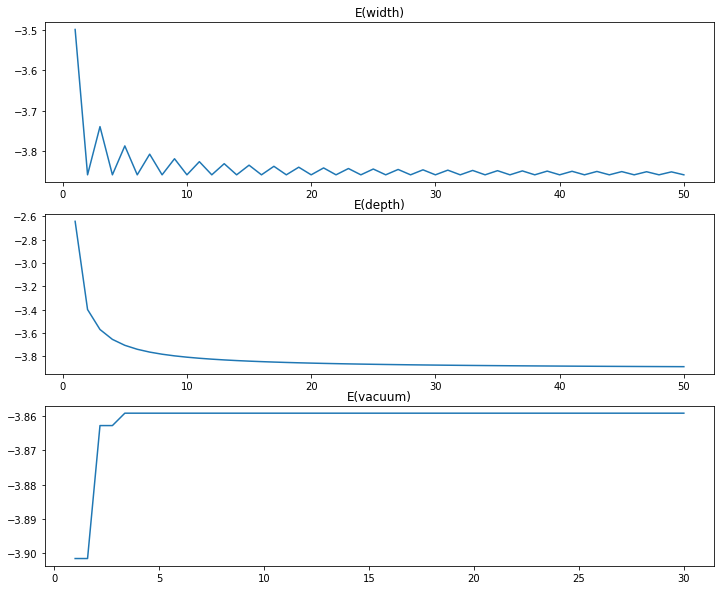

In [26]:
# defaults used for converging other params
width_def = 20
depth_def = 20
vacuum_def = 10

# maxima for convergence
width_max = 50
depth_max = 50
vacuum_max = 30

converge_slab(el=el, alat = alat_relax)

## Relax top two layers of converged slab configuration

In [27]:
width = 30 
depth = 30
vacuum = 10

In [28]:
# create surface slab
slab = fcc111(el, a=alat_relax, size=(width, width, depth))
print(slab.get_number_of_atoms())

# center along z-axis
slab.center(vacuum=vacuum, axis=2)
ase.io.write('slab_unrelaxed.cif', slab)
structure = Struc(ase2struc(slab))

27000


## Relax top n layers, freeze the rest

### top 2 layers 

In [29]:
runpath = Dir(path=os.path.join(workdir))
n_atoms = slab.get_number_of_atoms()
output_file = lammps_run(struc=structure, runpath=runpath, potential=potential, intemplate=input_template_fix2l, inparam={}, remote = remote)
energy_2l, lattice = get_lammps_energy(outfile=output_file)

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/lammps.in -log /home/sbatzner/ML-electron-density/EAM/lammps.log > /home/sbatzner/ML-electron-density/EAM/lammps.out


In [30]:
print("Relaxed slab energy/atom: {}".format(energy_2l/n_atoms))

Relaxed slab energy/atom: -3.876505877139482


### top 3 layers

In [31]:
runpath = Dir(path=os.path.join(workdir))
output_file = lammps_run(struc=structure, runpath=runpath, potential=potential, intemplate=input_template_fix3l, inparam={}, remote=remote)
energy_3l, lattice = get_lammps_energy(outfile=output_file)

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/lammps.in -log /home/sbatzner/ML-electron-density/EAM/lammps.log > /home/sbatzner/ML-electron-density/EAM/lammps.out


In [32]:
print("Relaxed slab energy/atom: {}".format(energy_3l/n_atoms))

Relaxed slab energy/atom: -3.8765083165900003


### top 4 layers

In [33]:
runpath = Dir(path=os.path.join(workdir))
output_file = lammps_run(struc=structure, runpath=runpath, potential=potential, intemplate=input_template_fix4l, inparam={}, remote=remote)
energy_4l, lattice = get_lammps_energy(outfile=output_file)

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/lammps.in -log /home/sbatzner/ML-electron-density/EAM/lammps.log > /home/sbatzner/ML-electron-density/EAM/lammps.out


In [34]:
print("Relaxed slab energy/atom: {}".format(energy_4l/n_atoms))

Relaxed slab energy/atom: -3.8765083164222593


## Read relaxed structure from top 2 layers dumpfile

In [35]:
def parse_structure_dump_wr(runpath, dumpfilename):
    dumpfile = os.path.join(runpath.path, dumpfilename)
    last_structure = read_lammps_dump(dumpfile)
    strucfile = os.path.join(runpath.path, 'slab_top2l_relaxed.cif')
    ase.io.write(strucfile, last_structure)
    return last_structure

## Add adsorbate and run MD 

In [36]:
slab = parse_structure_dump_wr(runpath = Dir(path=workdir), dumpfilename = 'fix2l_.out')
ada_delta_z = 2 # distance in z of adatom above top layer

# add adatom
x_min = np.amin(slab.positions[:, 0])
x_max = np.amax(slab.positions[:, 0])

y_min = np.amin(slab.positions[:, 1])
y_max = np.amax(slab.positions[:, 1])

ads_pos = (x_min + 0.5 * (x_max - x_min), y_min + 0.5 * (y_max - y_min))
add_adsorbate(slab, el, ada_delta_z, ads_pos)
ase.io.write('slab_with_ads.cif', slab)

# center along z-axis
slab.center(vacuum=vacuum, axis=2)
struc = Struc(ase2struc(slab))

## Note: This is currenlty tracking the MSD of the original adatom specified by atom ID. This will need to be updated to properly account for exchange mechanisms with the bulk atoms

## T = 1100 K 

In [37]:
# MD params
nsteps = 250000
temperature = 1100

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/lammps.in -log /home/sbatzner/ML-electron-density/EAM/lammps.log > /home/sbatzner/ML-electron-density/EAM/lammps.out


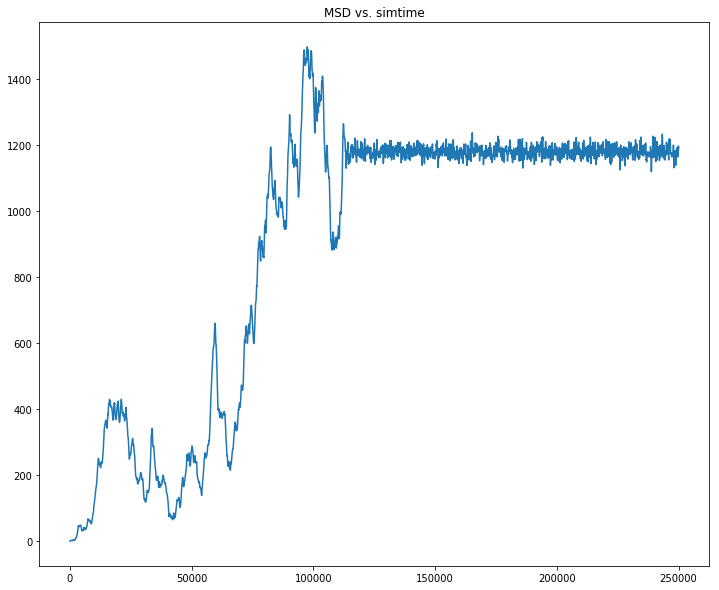

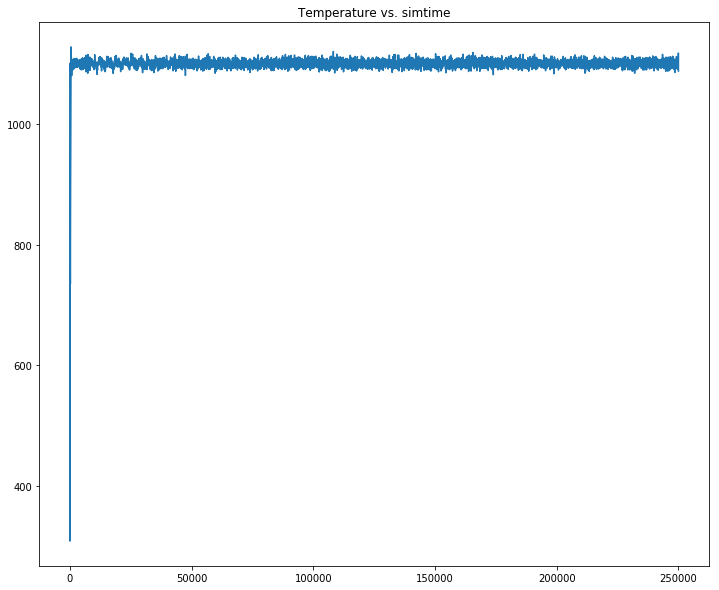

In [38]:
output, rdfs = md_run(el, alat_relax, nsteps, temperature, width, depth, vacuum, struc_type='slab', struc=struc)

In [39]:
!mv dump_ada.atom dump_ada_1100.atom

## T = 900 K 

In [40]:
# MD params
nsteps = 250000
temperature = 900

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/lammps.in -log /home/sbatzner/ML-electron-density/EAM/lammps.log > /home/sbatzner/ML-electron-density/EAM/lammps.out


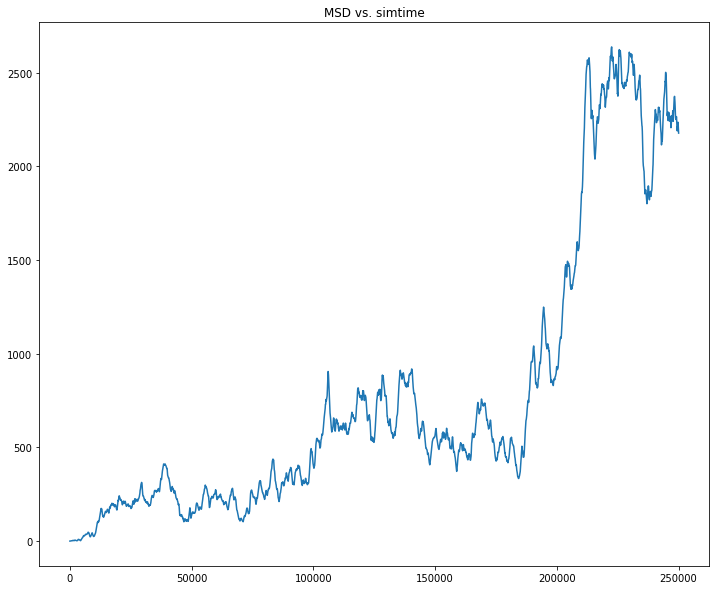

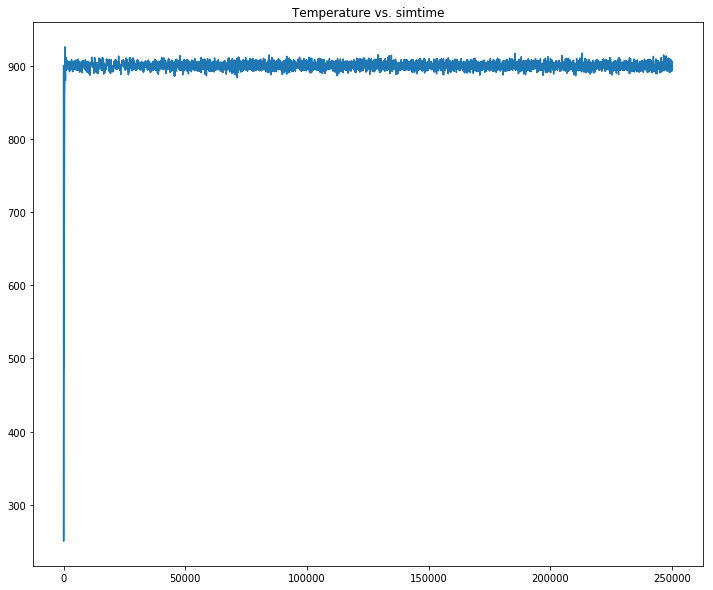

In [41]:
output, rdfs = md_run(el, alat_relax, nsteps, temperature, width, depth, vacuum, struc_type='slab', struc=struc)

In [42]:
!mv dump_ada.atom dump_ada_900.atom

# 2. Bulk Ag with a vacancy

In [43]:
el = 'Ag'
size = 3
alat_start = 4.0
potpath = os.path.join(os.environ['LAMMPS_POTENTIALS'], el + '_u3.eam')
potential = ClassicalPotential(path=potpath, ptype='eam', element=[el])

In [44]:
# create bulk cell
cell = crystal(el, [(0, 0, 0)], spacegroup=225, cellpar=[alat_start, alat_start, alat_start, 90, 90, 90])
n_atoms = cell.get_number_of_atoms()
structure = Struc(ase2struc(cell))

runpath = Dir(path=os.path.join(workdir, os.path.join('runs/bulk_vac')))
file_prefix = 'bulk_relax_' + str(alat_start) 
write(file_prefix + '.cif', cell, format='cif')

# run 
output_file = lammps_run(struc=structure, runpath=runpath, potential=potential, intemplate=input_template_relax, inparam={}, remote=remote)
energy, alat_relax = get_lammps_energy(outfile=output_file)

print(n_atoms)
print("Relaxed bulk energy/atom: {}".format(energy/n_atoms))
print("Relaxed lattice parameter: {0:.10f}".format(alat_relax))

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.out
4
Relaxed bulk energy/atom: -2.8500000015662
Relaxed lattice parameter: 4.0899999415


## Relax with vacancy 

### Note: when we relax with a bulk vacancy, don't allow the lattice parameter to adjust, that's unphysical; only allow that when we're relaxing the perfect cell

In [45]:
for size in range(2, 16): 
    print("\nSupercell size: {}\n".format(size))
    
    # create bulk cell
    cell = crystal(el, [(0, 0, 0)], spacegroup=225, cellpar=[alat_relax, alat_relax, alat_relax, 90, 90, 90])

    # make supercell
    multiplier = numpy.identity(3) * size
    supercell = make_supercell(cell, multiplier)

    # remove atom
    supercell.pop(supercell.get_number_of_atoms() // 2)
    cell = supercell

    # setup run
    n_atoms = cell.get_number_of_atoms()
    ase.io.write('bulk_vac.cif', cell)
    structure = Struc(ase2struc(cell))


    runpath = Dir(path=os.path.join(workdir, os.path.join('runs/bulk_vac')))
    file_prefix = 'bulk_relax_' + str(alat_start) 
    write(file_prefix + '.cif', cell, format='cif')

    # run 
    output_file = lammps_run(struc=structure, runpath=runpath, potential=potential, intemplate=input_template_relax_wo_vc, inparam={}, remote=remote)
    energy, alat_relax_vac = get_lammps_energy(outfile=output_file)

    print("Number of atoms: {}".format(n_atoms))
    print("Relaxed bulk energy/atom: {}".format(energy/n_atoms))
    print("Relaxed lattice parameter: {0:.10f}".format(alat_relax_vac/size))


Supercell size: 2

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.out
Number of atoms: 31
Relaxed bulk energy/atom: -2.8187229336907484
Relaxed lattice parameter: 4.0899999415

Supercell size: 3

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.out
Number of atoms: 107
Relaxed bulk energy/atom: -2.840964415897907
Relaxed lattice parameter: 4.0899999415

Supercell size: 4

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.in

In [46]:
size = 10

In [47]:
# create bulk cell
cell = crystal(el, [(0, 0, 0)], spacegroup=225, cellpar=[alat_relax, alat_relax, alat_relax, 90, 90, 90])

# make supercell
multiplier = numpy.identity(3) * size
supercell = make_supercell(cell, multiplier)

# remove atom
supercell.pop(supercell.get_number_of_atoms() // 2)
print(supercell.get_number_of_atoms() // 2)
# supercell.pop(supercell.get_number_of_atoms() // 4)
# supercell.pop(3 * supercell.get_number_of_atoms() // 4)
cell = supercell

# setup run
n_atoms = cell.get_number_of_atoms()
ase.io.write('bulk_vac.cif', cell)
structure = Struc(ase2struc(cell))


runpath = Dir(path=os.path.join(workdir, os.path.join('runs/bulk_vac')))
file_prefix = 'bulk_relax_' + str(alat_start) 
write(file_prefix + '.cif', cell, format='cif')

# run 
output_file = lammps_run(struc=structure, runpath=runpath, potential=potential, intemplate=input_template_relax_wo_vc, inparam={}, remote=remote)
energy, alat_relax_vac = get_lammps_energy(outfile=output_file)

1999
1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.in -log /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.log > /home/sbatzner/ML-electron-density/EAM/runs/bulk_vac/lammps.out


## Run MD for bulk with vacancy

In [48]:
struc = parse_structure_dump_wr(runpath = Dir(path=workdir), dumpfilename = 'rel_wo_vc.out')
struc = Struc(ase2struc(struc))
print(struc.n_atoms)

3999


## T = 1100 K 

In [49]:
# MD params
nsteps = 1000000
temperature = 1100

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/lammps.in -log /home/sbatzner/ML-electron-density/EAM/lammps.log > /home/sbatzner/ML-electron-density/EAM/lammps.out


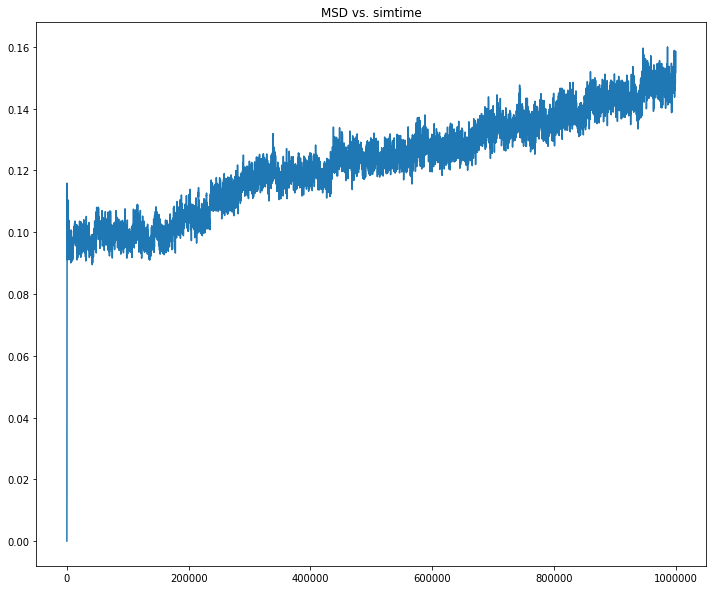

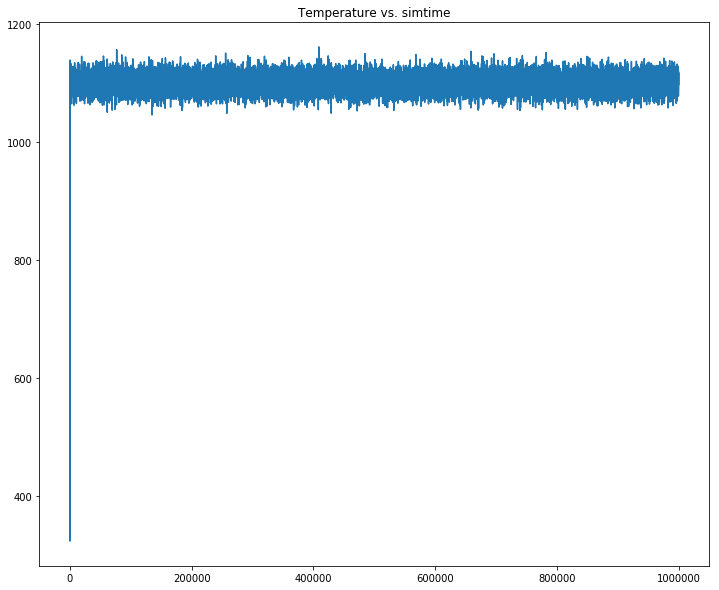

In [50]:
output, rdfs = md_run(el, alat_relax, nsteps, temperature, None, None, None, struc_type='bulk_vacancy', struc = struc)

In [51]:
!mv dump_bulkvac.atom dump_bulkvac_1100.atom

## T = 900 K 

In [52]:
# MD params
nsteps = 1000000
temperature = 900

1
Running lammps remotely...

mpirun -np 32 /home/sbatzner/lammps-16Mar18/src/lmp_mpi -in /home/sbatzner/ML-electron-density/EAM/lammps.in -log /home/sbatzner/ML-electron-density/EAM/lammps.log > /home/sbatzner/ML-electron-density/EAM/lammps.out


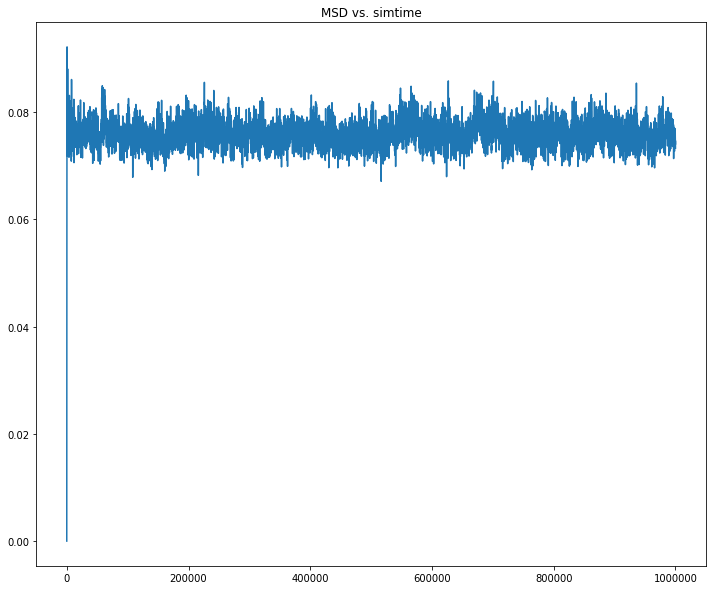

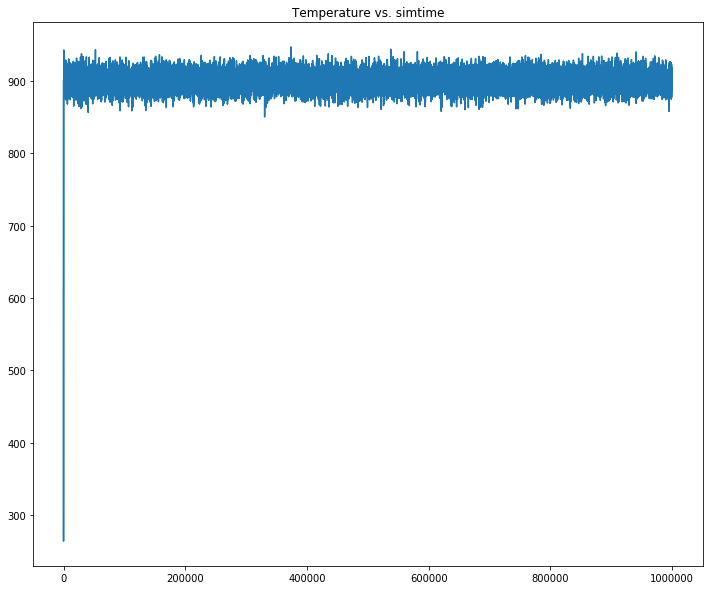

In [53]:
output, rdfs = md_run(el, alat_relax, nsteps, temperature, None, None, None, struc_type='bulk_vacancy', struc = struc)

In [54]:
!mv dump_bulkvac.atom dump_bulkvac_900.atom